In [1]:
import numpy as np
from numpy import random, cos, sin, sqrt, pi
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import pandas as pd
from tqdm import tqdm
from numpy.linalg import multi_dot
from scipy.linalg import eig, eigh, solve
import inspect
import sklearn.metrics.pairwise as skp
import zipfile, os, pickle
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from scipy.sparse.csgraph import connected_components
from sklearn import manifold, datasets
from time import time
from matplotlib.ticker import NullFormatter

In [289]:
def disturb(x, n, sigma):
    eps = random.normal(loc=0, scale=sigma, size=n)
    return x + eps

def set_options(ax):
    ax.grid(False)
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    
def rand_sphere(n, r, sigma):
    z = r * (2 * random.rand(n) - 1)   # uniform in -r, r
    t = 2 * pi * random.rand(n)   # uniform in 0, 2*pi
    x = sqrt(r**2 - z**2) * cos(t)
    y = sqrt(r**2 - z**2) * sin(t)
    x = disturb(x, n, sigma); y = disturb(y, n, sigma); z = disturb(z, n, sigma)
    return x, y, z

def synthetic_noise(N, r1, r2, r3, sigma, show=True):    
    p1 = rand_sphere(int(N/3), r1, sigma)
    p2 = rand_sphere(int(N/3), r2, sigma)
    p3 = rand_sphere(int(N/3), r3, sigma)
    data1 = pd.DataFrame({'V1': p1[0], 'V2': p1[1], 'V3': p1[2], 'Y': np.ones(p1[0].shape).astype(int)})
    data2 = pd.DataFrame({'V1': p2[0], 'V2': p2[1], 'V3': p2[2], 'Y': (2*np.ones(p2[0].shape)).astype(int)})
    data3 = pd.DataFrame({'V1': p3[0], 'V2': p3[1], 'V3': p3[2], 'Y': (3*np.ones(p3[0].shape)).astype(int)})
    data = pd.concat((data1, data2, data3), axis=0)
    data = data.sample(frac=1).reset_index(drop=True)
    if show:
        x, y, z = p1
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, label='Class 1')
        x, y, z = p2
        ax.scatter(x, y, z, label='Class 2')
        x, y, z = p3
        ax.scatter(x, y, z, label='Class 3')
        set_options(ax)
        plt.legend(); plt.show()
    return data

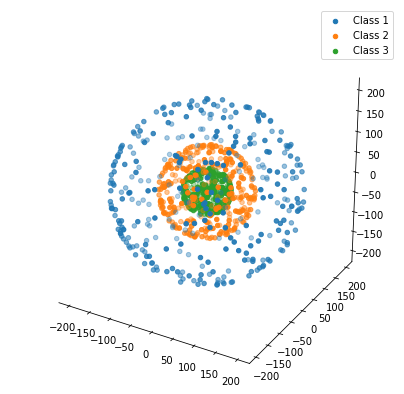

In [290]:
data = np.array(synthetic_noise(1000, 200, 100, 50, 0))

Kernel PCA

In [11]:
def centering(K):
    """
    Center kernel
    :param K: np.array
    :return: np.array
    """
    n = K.shape[0]
    B = np.eye(n) - np.ones((n, n))/n
    return multi_dot([B, K, B])

def gaussian(X, sigma):
    return skp.rbf_kernel(X, gamma=sigma)

def polynomial(X, d):
    return skp.polynomial_kernel(X, degree=d)

def sigmoid(X, gamma):
    return skp.sigmoid_kernel(X, gamma=gamma)

In [22]:
class kernelPCA():
    def __init__(self, method, params, p, verbose=False):
        self.method = method
        self.params = params
        self.p = p
        self.verboseprint = print if verbose else lambda *a, **k: None
        
    def fit(self, X_train):
        self.X_train = X_train
        self.verboseprint('...Computing Gram matrix...')
        self.K = self.getK(X_train)
        self.verboseprint('...Computing eigenvectors...')
        eigVl, eigVc = self.getEigs(self.K)
        eigVc /= np.sqrt(eigVl)
        self.alpha = eigVc
        
    def fit_transform(self, X_train):
        self.fit(X_train)
        new_X = self.newData(X_train)
        self.verboseprint('...Projecting onto a{:3.0f}-dimensional space...'.format(self.p))
        for i in range(X_train.shape[0]):
            Ki = self.K[i]
            for k in range(self.p):
                new_X.iloc[i, k] = np.dot(Ki, self.alpha[:, k])
        return new_X
    
    def transform(self, X_test):
        new_X = self.newData(X_test)
        self.X_test = X_test
        self.verboseprint('...Projecting on test...')
        for i, x_test in enumerate(self.X_test[:, :-1]):
            v = []
            for j, x_train in enumerate(self.X_train[:, :-1]):
                v.append(self.phi(x_test, x_train))
            for k in range(self.p):
                new_X.iloc[i, k] = np.dot(np.array(v), self.alpha[:, k])
        return new_X
    
    def newData(self, X):
        n = X.shape[0]
        z = np.zeros(n)
        dict_ = dict(zip(['a'+str(i) for i in range(self.p)], [z]*self.p))
        dict_['Y'] = X[:, -1]
        new_X = pd.DataFrame(dict_)
        return new_X
        
    def getEigs(self, K):
        eigenValues, eigenVectors = eigh(K)
        idx = eigenValues.argsort()[::-1][:self.p]
        return eigenValues[idx], eigenVectors[:, idx]

    def getK(self, X):
        if self.method.__name__ == 'gaussian':
            sigma = self.params['sigma']
            K = centering(gaussian(X, sigma=0.5/sigma**2))
            self.phi = lambda x,y : np.exp(-0.5 * np.linalg.norm(x-y, ord=2)**2 / sigma**2)
        elif self.method.__name__ == 'polynomial':
            d = self.params['d']
            K = centering(polynomial(X, d=d))
            self.phi = lambda x,y : np.dot(x, y)**d
        elif self.method.__name__ == 'sigmoid':
            gamma = self.params['gamma']
            K = centering(sigmoid(X, gamma=gamma))
            self.phi = lambda x,y : np.tanh(gamma * np.dot(x, y))
        return K

In [31]:
class LEM():
    def __init__(self, k, p, reg, gamma, verbose=False):
        self.k = k 
        self.p = p
        self.reg = reg
        self.gamma = gamma
        self.verboseprint = print if verbose else lambda *a, **k: None
        
    def fit(self, X):
        self.nbrs = NearestNeighbors(n_neighbors=self.k+1, algorithm='ball_tree').fit(X)
        self.neighbors = self.nbrs.kneighbors(X, n_neighbors=self.k+1, return_distance=False)[:, 1:]
        graph = self.nbrs.kneighbors_graph(X).toarray()
        self.graph = np.maximum(graph, graph.T)
        self.n_components, self.labels = connected_components(csgraph=csr_matrix(graph), directed=False, return_labels=True)
        self.verboseprint('Number of connected components: {:3.0f}'.format(self.n_components))
        W = gaussian(X, sigma=0.25/self.gamma) * self.graph
        D = np.diag([np.sum(W[i]) for i in range(W.shape[0])])
        L = D-W
        vals, vecs = eigh(a=L, b=D) 
        idx = vals.argsort()[1:self.p+1]
        self.eigVl = vals[idx]
        self.eigVc = vecs[:, idx]
        
    def get_weigths(self, X):
        Weights = np.empty((X.shape[0], self.k))
        v = np.ones(self.k, dtype=X.dtype)
        for i, x in enumerate(X):
            ind = self.neighbors[i]
            Nx = X[ind]
            G = np.dot((x-Nx), (x-Nx).T)
            trace = np.trace(G)
            if trace > 0:
                R = self.reg * trace
            else:
                R = self.reg
            G += R * np.eye(self.k)
            w = solve(G, v, sym_pos=True)
            Weights[i] = w / np.sum(w)
        return Weights

    def fit_transform(self, X, y):
        self.fit(X)
        self.Weights = self.get_weigths(X)
        new_X = self.newData(X, y)
        self.verboseprint('Projecting onto a{:3.0f}-dimensional space'.format(self.p))
        for i in range(X.shape[0]):
            ind = self.neighbors[i]
            eigs = self.eigVc[ind]
            w = self.Weights[i]
            new_X.iloc[i, :self.isy] = np.sum((w * eigs.T[:, None]).T, axis=0)
        self.verboseprint('Done.')
        return new_X
    
    
    def transform(self, X, y):
        v = np.ones(self.k, dtype=X.dtype)
        new_X = self.newData(X, y)
        neighbors_test = self.nbrs.kneighbors(X, n_neighbors=self.k, return_distance=False)
        for i, x in enumerate(X_test):
            ind = neighbors_test[i]
            eigs = self.eigVc[ind]
            Nx = X[ind]
            G = np.dot((x-Nx), (x-Nx).T)
            trace = np.trace(G)
            if trace > 0:
                R = self.reg * trace
            else:
                R = self.reg
            G += R * np.eye(self.k)
            w = solve(G, v, sym_pos=True)
            new_X.iloc[i, :self.isy] = np.sum(((w / np.sum(w)) * eigs.T[:, None]).T, axis=0)
        return new_X
    
    def newData(self, X, y):
        n = X.shape[0]
        z = np.zeros(n)
        dict_ = dict(zip(['a'+str(i) for i in range(self.p)], [z]*self.p))
        if y is not None:
            dict_['Y'] = y
            self.isy = -1
        else:
            self.isy = self.p+1
        new_X = pd.DataFrame(dict_)
        return new_X

In [24]:
class LLE():
    def __init__(self, k, p, reg, verbose=False):
        self.k = k 
        self.p = p
        self.reg = reg
        self.verboseprint = print if verbose else lambda *a, **k: None
        
    def fit(self, X):
        self.nbrs = NearestNeighbors(n_neighbors=self.k+1, algorithm='ball_tree').fit(X)
        self.neighbors = self.nbrs.kneighbors(X, n_neighbors=self.k+1, return_distance=False)
        self.W, self.Weights = self.get_weigths(X)
        n = self.W.shape[0]
        L = np.dot((np.eye(n)-self.W).T, np.eye(n)-self.W)
        vals, vecs = eigh(a=L)
        idx = vals.argsort()[1:self.p+1]
        self.eigVl = vals[idx]
        self.eigVc = vecs[:, idx]
        
    def get_weigths(self, X):
        W = np.zeros((X.shape[0], X.shape[0]))
        Weights = np.empty((X.shape[0], self.k))
        v = np.ones(self.k, dtype=X.dtype)
        for i, x in enumerate(X):
            ind = self.neighbors[i, 1:]
            Nx = X[ind]
            G = np.dot((x-Nx), (x-Nx).T)
            trace = np.trace(G)
            if trace > 0:
                R = self.reg * trace
            else:
                R = self.reg
            G += R * np.eye(self.k)
            w = solve(G, v, sym_pos=True)
            W[i, ind] = w / np.sum(w)
            Weights[i] = w / np.sum(w)
        return W, Weights

    def fit_transform(self, X, y):
        self.fit(X)
        new_X = self.newData(X, y)
        self.verboseprint('...Projecting onto a{:3.0f}-dimensional space...'.format(self.p))
        for i in range(X.shape[0]):
            ind = self.neighbors[i, 1:]
            eigs = self.eigVc[ind]
            w = self.Weights[i]
            new_X.iloc[i, :self.isy] = np.sum((w * eigs.T[:, None]).T, axis=0)
        return new_X
    
    
    def transform(self, X, y):
        v = np.ones(self.k, dtype=X.dtype)
        new_X = self.newData(X, y)
        neighbors_test = self.nbrs.kneighbors(X, n_neighbors=self.k, return_distance=False)
        for i, x in enumerate(X):
            ind = neighbors_test[i]
            eigs = self.eigVc[ind]
            Nx = X[ind]
            G = np.dot((x-Nx), (x-Nx).T)
            trace = np.trace(G)
            if trace > 0:
                R = self.reg * trace
            else:
                R = self.reg
            G += R * np.eye(self.k)
            w = solve(G, v, sym_pos=True)
            new_X.iloc[i, :self.isy] = np.sum(((w / np.sum(w)) * eigs.T[:, None]).T, axis=0)
        return new_X
    
    def newData(self, X, y):
        n = X.shape[0]
        z = np.zeros(n)
        dict_ = dict(zip(['a'+str(i) for i in range(self.p)], [z]*self.p))
        if y is not None:
            dict_['Y'] = y
            self.isy = -1
        else:
            self.isy = self.p+1
        new_X = pd.DataFrame(dict_)
        return new_X

In [5]:
class MDS():
    def __init__(self, p, verbose=False):
        self.p = p
        self.verboseprint = print if verbose else lambda *a, **k: None
        
    def fit(self, X):
        X_c = X-X.mean(axis=0)
        self.S = np.dot(X_c, X_c.T)
        vals, vecs = eigh(a=self.S)
        idx = vals.argsort()[::-1]
        self.eigVl = np.abs(vals[idx])
        self.eigVc = vecs[:, idx]
        
    def fit_transform(self, X, y):
        self.fit(X)
        new_X = self.newData(X, y)
        new_X.iloc[:, :self.isy] = multi_dot((np.eye(self.p, X.shape[0]),
                                              np.sqrt(np.diag(self.eigVl)),
                                              self.eigVc.T)).T
        return new_X
    
    def newData(self, X, y):
        n = X.shape[0]
        z = np.zeros(n)
        dict_ = dict(zip(['a'+str(i) for i in range(self.p)], [z]*self.p))
        if y is not None:
            dict_['Y'] = y
            self.isy = -1
        else:
            self.isy = self.p+1
        new_X = pd.DataFrame(dict_)
        return new_X

In [6]:
def plot_results(X, title, color=None):
    if type(X) == np.ndarray:
        X = pd.DataFrame()
    Y = X.iloc[:, -1]
    if np.unique(Y).shape[0] > 10:
        plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=color, cmap=plt.cm.Spectral)
        plt.title(title)
        plt.axis('tight')
    else:
        classes = Y.unique()
        plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=X.iloc[:, 2], cmap=plt.cm.get_cmap('jet', len(classes)))
        plt.colorbar(ticks=range(len(classes)+1))
        plt.clim(np.min(classes)-0.5, np.max(classes)+0.5)
        plt.title(title)

Done.


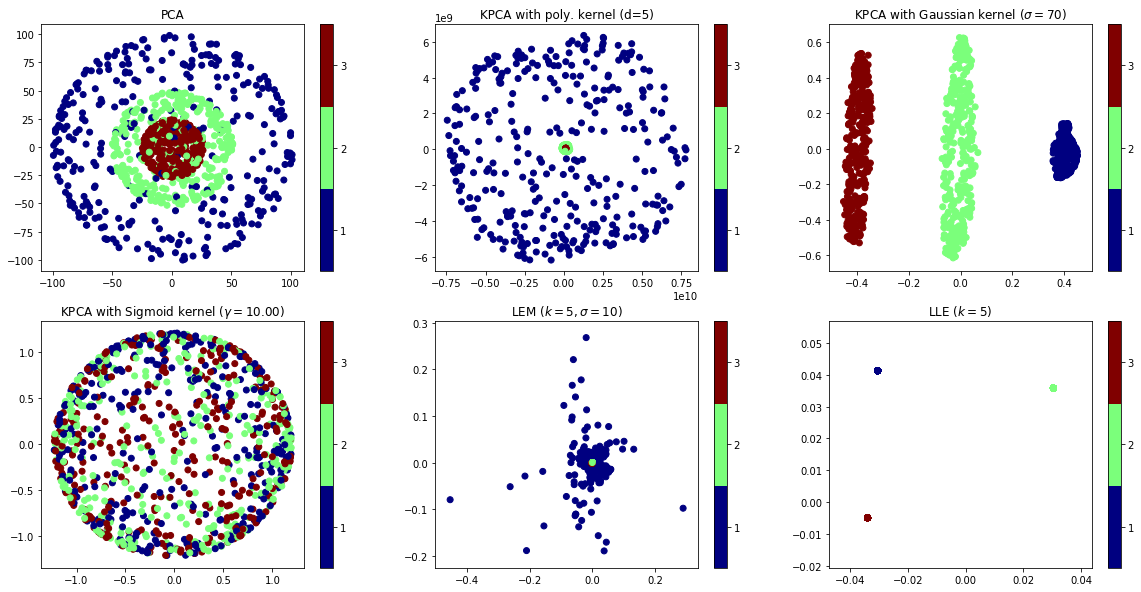

In [1464]:
plt.figure(figsize=(20, 10))

data = np.array(synthetic_noise(1000, 200, 100, 50, 1, False))
method = polynomial
kpca = kernelPCA(method, {'d': 1}, 2, verbose=False)
train_new = kpca.fit_transform(data)
plt.subplot(2, 3, 1)
plot_results(train_new, title='PCA')

#
method = polynomial
kpca = kernelPCA(method, {'d': 5}, 2, verbose=False)
train_new = kpca.fit_transform(data)
plt.subplot(2, 3, 2)
plot_results(train_new, title='KPCA with poly. kernel (d=5)')

#
method = gaussian
sigma = 70
kpca = kernelPCA(method, {'sigma': sigma}, 2, verbose=False)
train_new = kpca.fit_transform(data)
plt.subplot(2, 3, 3)
plot_results(train_new, title='KPCA with Gaussian kernel ($\sigma={:3.0f}$)'.format(sigma))

#
method = sigmoid
gamma = 10
kpca = kernelPCA(method, {'gamma': gamma}, 2, verbose=False)
train_new = kpca.fit_transform(data)
plt.subplot(2, 3, 4)
plot_results(train_new, title='KPCA with Sigmoid kernel ($\gamma={:3.2f}$)'.format(gamma))

#
gamma = 10
k = 5
L=LEM(k=k, p=2, gamma=gamma, verbose=False)
train_new = L.fit_transform(data, data[:, -1], reg=1e-3)
plt.subplot(2, 3, 5)
plot_results(train_new, title='LEM ($k={:3.0f}, \sigma={:3.0f}$)'.format(k, gamma))

#
k = 5
L=LLE(k=k, p=2, verbose=False)
train_new = L.fit_transform(data, data[:, -1], reg=1e-3)
plt.subplot(2, 3, 6)
plot_results(train_new, title='LLE ($k={:3.0f}$)'.format(k, gamma))

plt.subplots_adjust()
plt.show()

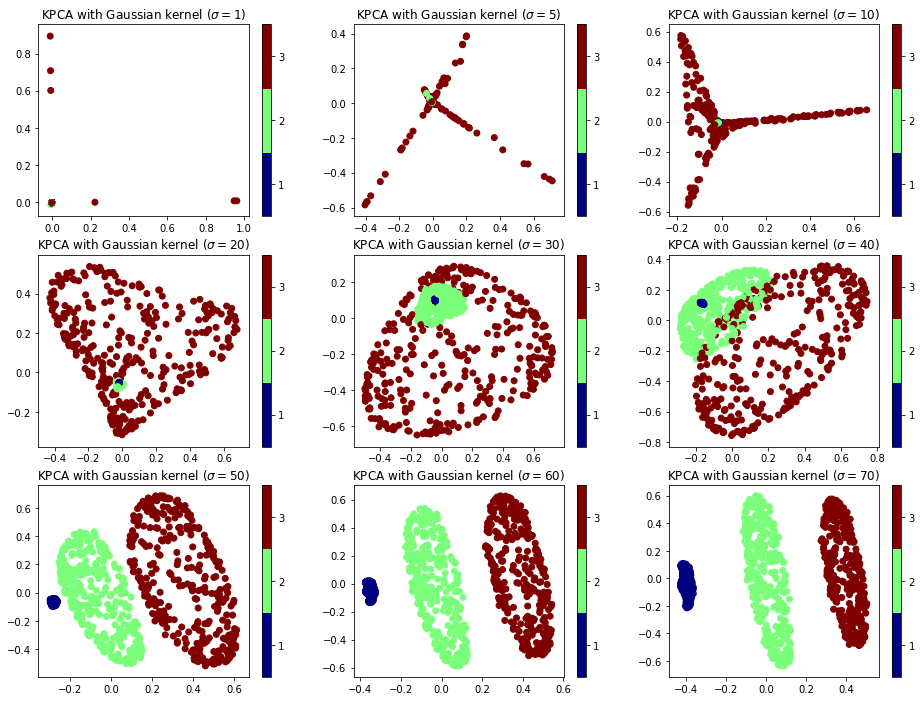

In [1113]:
plt.figure(figsize=(16, 12))
method = gaussian
for i, sigma in enumerate([1, 5, 10, 20, 30, 40, 50, 60, 70]):
    kpca = kernelPCA(method, {'sigma': sigma}, 2, verbose=False)
    train_new = kpca.fit_transform(data)
    plt.subplot(3, 3, i+1)
    plot_results(train_new, title=r'KPCA with Gaussian kernel ($\sigma={:3.0f}$)'.format(sigma))
plt.subplots_adjust()
plt.show()

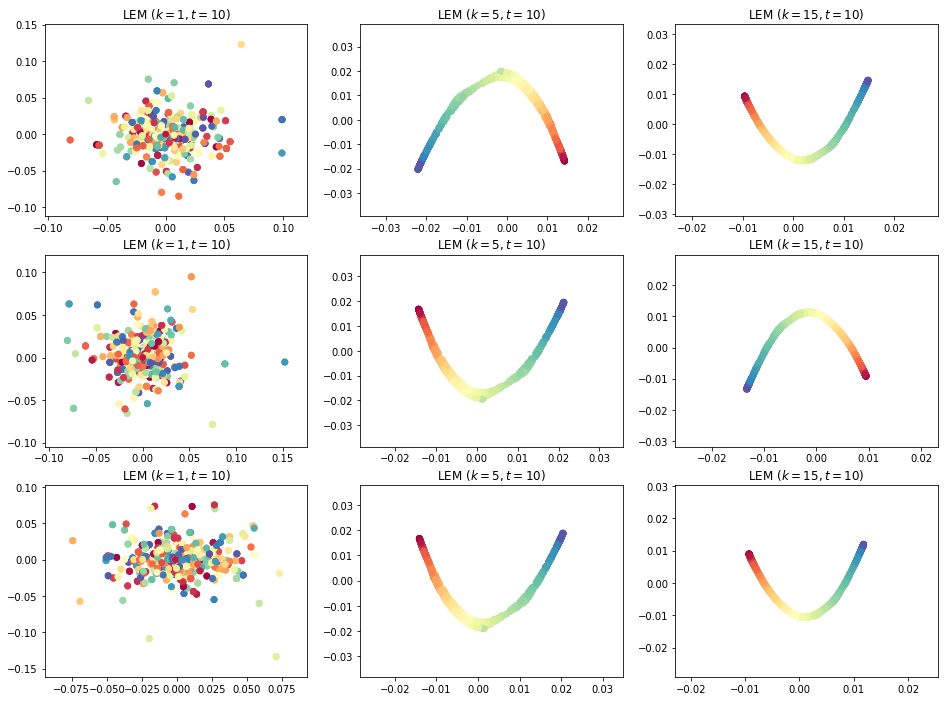

In [1269]:
data, color = datasets.samples_generator.make_swiss_roll(1000, noise=0)
plt.figure(figsize=(16, 12))
method = gaussian
for i, (k, t) in enumerate(zip([1, 5, 15, 1, 5, 15, 1, 5, 15], [5, 5, 5, 10, 10, 10, 1e3, 1e3, 1e3])):
    L=LEM(k=k, p=2, gamma=t, verbose=False)
    train_new = L.fit_transform(data, data[:, -1], reg=1e-3)
    plt.subplot(3, 3, i+1)
    plot_results(train_new, title='LEM ($k={:3.0f}, t={:3.0f}$)'.format(k, gamma), color=color)
plt.subplots_adjust()
plt.show()

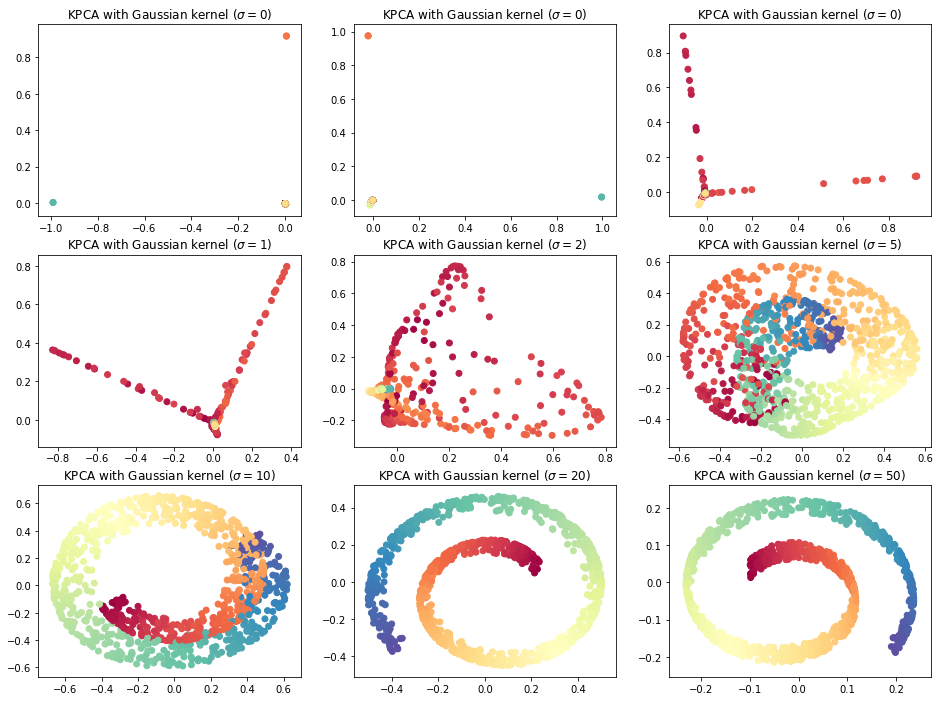

In [1121]:
plt.figure(figsize=(16, 12))
method = gaussian
for i, sigma in enumerate([0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 50]):
    kpca = kernelPCA(method, {'sigma': sigma}, 2, verbose=False)
    train_new = kpca.fit_transform(data)
    plt.subplot(3, 3, i+1)
    plot_results(train_new, title=r'KPCA with Gaussian kernel ($\sigma={:3.0f}$)'.format(sigma), color=color)
plt.subplots_adjust()
plt.show()

Comparison with scikit learn

PCA (Own): 0.71 sec
Metric MDS (Sklearn): 3.5 sec
MDS (Own): 3.5 sec
KPCA (Poly. d=5): 0.85 sec
KPCA (Gaussian, sigma=10): 0.88 sec
LLE (Sklearn, k=10): 0.21 sec
Hessian LLE (Sklearn, k=10): 0.53 sec
LLE (Own, k=10): 1.1 sec
LEM (Own, k=10): 0.95 sec
LEM (Sklearn, k=10): 0.1 sec
Isomap (Sklearn, k=10): 0.51 sec
t-SNE (Sklearn): 9.4 sec


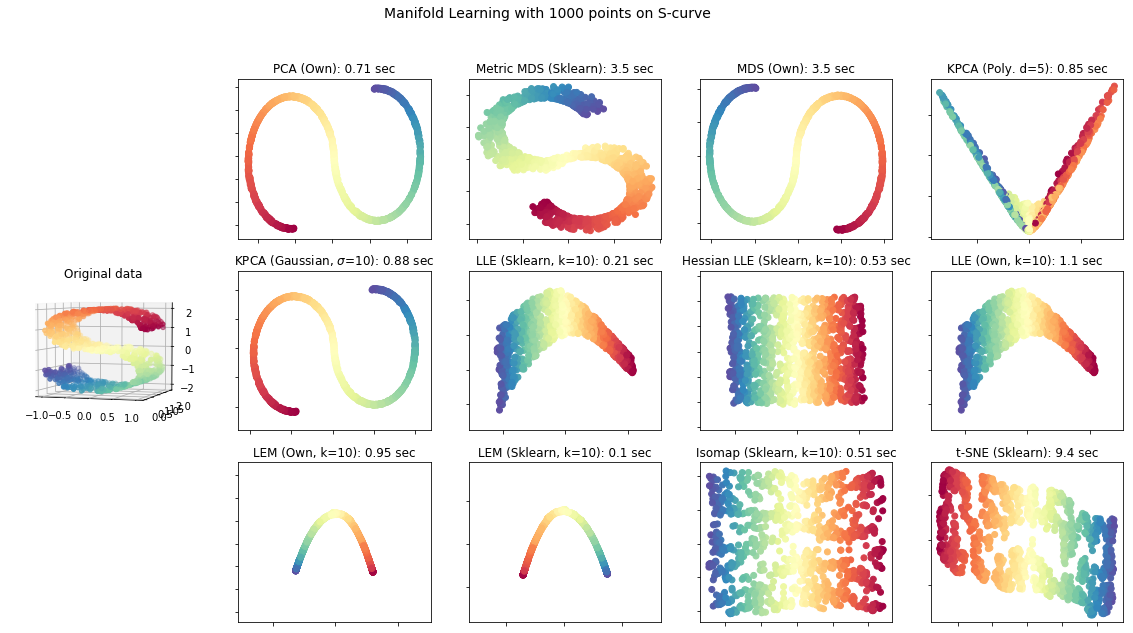

In [1640]:
# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
data = datasets.samples_generator.make_s_curve(n_points, random_state=0)
title = "Manifold Learning with %i points on S-curve" % (n_points)
params = {'kpca-poly': {'d': 5},
          'kpca-gaussian': {'sigma': 10},
          'LLE': {'k': 10},
          'LEM': {'k': 10, 'gamma': 10},
          'ISO': {'k': 10},
          'SDE': {'k': 10}
         }

def comparison(data, n_components, params, title):
    X, color= data
    fig = plt.figure(figsize=(20, 10))
    plt.suptitle(title, fontsize=14)

    ax = fig.add_subplot(356, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
    plt.title('Original data')
    ax.view_init(4, -72)

    method = polynomial
    kpca = kernelPCA(method, {'d': 1}, n_components, verbose=False)
    t0 = time()
    Y = kpca.fit_transform(X)
    t1 = time()
    print("PCA (Own): %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(352)
    plot_results(Y, title='PCA (Own): %.2g sec' % (t1 - t0), color=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    mds = manifold.MDS(n_components, max_iter=100, n_init=1)
    Y = mds.fit_transform(X)
    t1 = time()
    print("Metric MDS (Sklearn): %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(353)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("Metric MDS (Sklearn): %.2g sec" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    mds_ = MDS(p=n_components)
    Y = mds_.fit_transform(X, None)
    ax = fig.add_subplot(354)
    plot_results(Y, title="MDS (Own): %.2g sec" % (t1 - t0), color=color)
    print("MDS (Own): %.2g sec" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    method = polynomial
    d = params['kpca-poly']['d']
    kpca = kernelPCA(method, {'d': d}, n_components, verbose=False)
    t0 = time()
    Y = kpca.fit_transform(X)
    t1 = time()
    print("KPCA (Poly. d=%.2g): %.2g sec" % (d, t1 - t0))
    ax = fig.add_subplot(355)
    plot_results(Y, title="KPCA (Poly. d=%.2g): %.2g sec" % (d, t1 - t0), color=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    method = gaussian
    sigma = params['kpca-gaussian']['sigma']
    kpca = kernelPCA(method, {'sigma': 10}, n_components, verbose=False)
    t0 = time()
    Y = kpca.fit_transform(X)
    t1 = time()
    print(r"KPCA (Gaussian, sigma=%.2g): %.2g sec" % (sigma, t1 - t0))
    ax = fig.add_subplot(357)
    plot_results(Y, title=r"KPCA (Gaussian, $\sigma$=%.2g): %.2g sec" % (sigma, t1 - t0), color=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    n_neighbors = params['LLE']['k']
    methods = ['standard', 'hessian']
    labels = ['LLE (Sklearn, k=%.2g)' % n_neighbors, 'Hessian LLE (Sklearn, k=%.2g)' % n_neighbors]

    for i, method in enumerate(methods):
        t0 = time()
        Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                            eigen_solver='auto',
                                            method=method).fit_transform(X)
        t1 = time()
        print("%s: %.2g sec" % (labels[i], t1 - t0))

        ax = fig.add_subplot(3, 5, 8+i)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
        plt.title("%s: %.2g sec" % (labels[i], t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

    n_neighbors = params['LLE']['k']
    L=LLE(k=n_neighbors, p=2, verbose=False)
    t0 = time()
    Y = L.fit_transform(X, None, reg=1e-3)
    t1= time()
    print("LLE (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 10)
    plot_results(Y, title="LLE (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0), color=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    
    n_neighbors = params['LEM']['k']
    gamma = params['LEM']['gamma']
    L=LEM(k=n_neighbors, p=2, gamma=gamma, verbose=False)
    t0 = time()
    Y = L.fit_transform(X, None, reg=1e-8)
    t1 = time()
    print("LEM (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 12)
    plot_results(Y, title="LEM (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0), color=color)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    n_neighbors = params['SDE']['k']
    se = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors)
    Y = se.fit_transform(X)
    t1 = time()
    print("LEM (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 13)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("LEM (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    

    t0 = time()
    n_neighbors = params['ISO']['k']
    Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
    t1 = time()
    print("Isomap (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 14)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("Isomap (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("t-SNE (Sklearn): %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(3, 5, 15)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("t-SNE (Sklearn): %.2g sec" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    plt.show()
    
comparison(data=data, n_components=2, params=params, title=title)

PCA (Own): 0.71 sec
Metric MDS (Sklearn): 2.9 sec
MDS (Own): 2.9 sec
KPCA (Poly. d=5): 0.73 sec
KPCA (Gaussian, sigma=10): 0.72 sec
LLE (Sklearn, k=10): 0.21 sec
Hessian LLE (Sklearn, k=10): 0.49 sec
LLE (Own, k=10): 0.84 sec
LEM (Own, k=10): 0.85 sec
LEM (Sklearn, k=10): 0.11 sec
Isomap (Sklearn, k=10): 0.42 sec
t-SNE (Sklearn): 6.8 sec


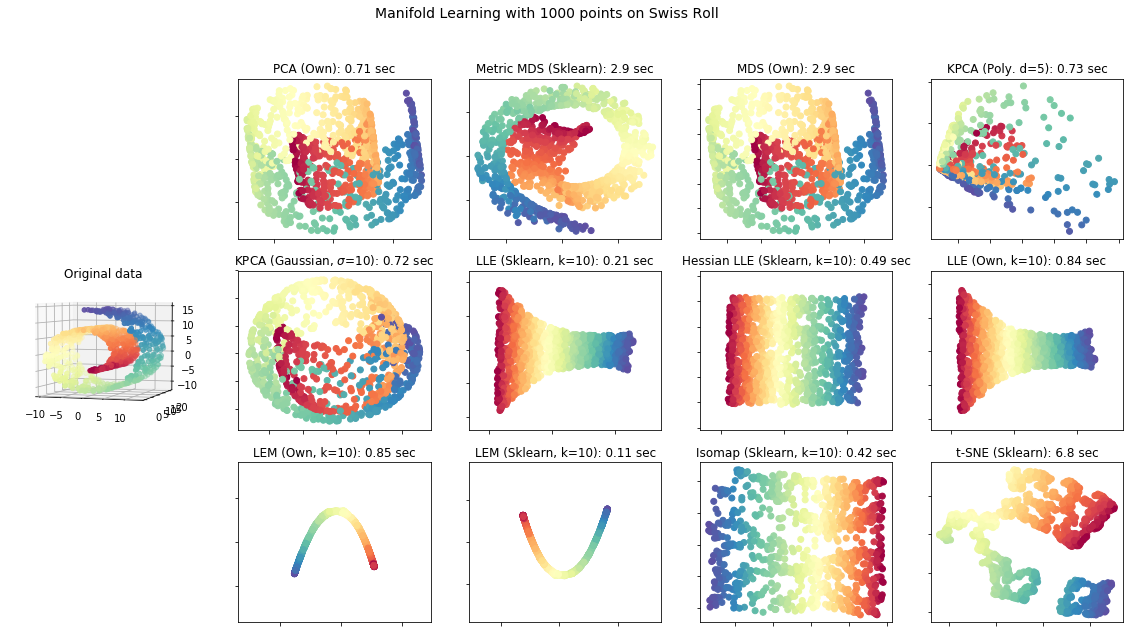

In [1637]:
n_points = 1000
data = datasets.samples_generator.make_swiss_roll(n_points, random_state=0)
title = "Manifold Learning with %i points on Swiss Roll" % (n_points)
params = {'kpca-poly': {'d': 5},
          'kpca-gaussian': {'sigma': 10},
          'LLE': {'k': 10},
          'LEM': {'k': 10, 'gamma': 10},
          'ISO': {'k': 10},
          'SDE': {'k': 10}
         }
comparison(data=data, n_components=2, params=params, title=title)

Load MNIST dataset

In [7]:
path = '/Users/bfiliot/Desktop/ENSAE/3A/STATS_AV/'

def format(X):
    d = pd.DataFrame(X[0])
    d.columns = ['V'+str(i+1) for i in range(d.shape[1])]
    d['Y'] = X[1]
    return d

def load_data(path):
    zip_ref = zipfile.ZipFile(os.path.join(path, 'Data/mnist.pkl.gz'), 'r')
    zip_ref.extractall(os.path.join(path, 'Data'))
    zip_ref.close()
    train, valid, test = pickle.load(open(os.path.join(path, 'Data/mnist.pkl'), 'rb'), encoding='latin1')
    train, valid, test = format(train), format(valid), format(test) 
    return train, valid, test

train, valid, test = load_data(path)

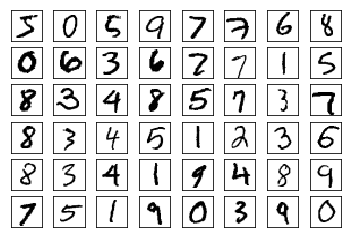

In [8]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(np.array(train.iloc[1000 * i, :-1]).reshape(28, 28), cmap='gray_r')

In [ ]:
Axes3D

N_train, N_test = 2000, 400
train_set = np.array(train[:N_train])
test_set = np.array(test[:N_test])
titles = ["Manifold Learning with %i training points on MNIST" % (N_train),
          "Manifold Learning with %i training points on MNIST" % (N_test)]

params = {'kpca-poly': {'d': 5},
          'kpca-gaussian': {'sigma': 50},
          'LLE': {'k': 30},
          'LEM': {'k': 30, 'gamma': 50},
          'ISO': {'k': 30},
          'SDE': {'k': 30}
         }

def comparison_MNIST(train, test, n_components, params, titles, testing=False):    
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test = test[:, :-1], test[:, -1]
    fig = plt.figure(figsize=(20, 10))
    plt.suptitle(titles[0], fontsize=14)

    print('Training...')
    method = polynomial
    KPCA1 = kernelPCA(method, {'d': 1}, n_components, verbose=False)
    t0 = time()
    Y = KPCA1.fit_transform(train)
    t1 = time()
    print("PCA (Own): %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(352)
    plot_results(Y, title='PCA (Own): %.2g sec' % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    MDS1 = manifold.MDS(n_components, max_iter=100, n_init=1)
    Y = MDS1.fit_transform(train)
    Y = pd.DataFrame(Y)
    Y['Y'] = y_train
    t1 = time()
    print("Metric MDS (Sklearn): %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(353)
    plot_results(Y, title="Metric MDS (Sklearn): %.2g sec" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    MDS2 = MDS(p=n_components)
    Y = MDS2.fit_transform(X_train, y_train)
    ax = fig.add_subplot(354)
    plot_results(Y, title="MDS (Own): %.2g sec" % (t1 - t0))
    print("MDS (Own): %.2g sec" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    method = polynomial
    d = params['kpca-poly']['d']
    KPCA2 = kernelPCA(method, {'d': d}, n_components, verbose=False)
    t0 = time()
    Y = KPCA2.fit_transform(train)
    t1 = time()
    print("KPCA (Poly. d=%.2g): %.2g sec" % (d, t1 - t0))
    ax = fig.add_subplot(355)
    plot_results(Y, title="KPCA (Poly. d=%.2g): %.2g sec" % (d, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    method = gaussian
    sigma = params['kpca-gaussian']['sigma']
    KPCA3 = kernelPCA(method, {'sigma': 10}, n_components, verbose=False)
    t0 = time()
    Y = KPCA3.fit_transform(train)
    t1 = time()
    print(r"KPCA (Gaussian, sigma=%.2g): %.2g sec" % (sigma, t1 - t0))
    ax = fig.add_subplot(357)
    plot_results(Y, title=r"KPCA (Gaussian, $\sigma$=%.2g): %.2g sec" % (sigma, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    n_neighbors = params['LLE']['k']
    methods = ['standard', 'hessian']
    labels = ['LLE (Sklearn, k=%.2g)' % n_neighbors, 'Hessian LLE (Sklearn, k=%.2g)' % n_neighbors]

    for i, method in enumerate(methods):
        t0 = time()
        LLE_ = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                              eigen_solver='dense',
                                              method=method)
        if i==1:
            LLE1 = LLE_
            Y = LLE1.fit_transform(X_train)
        else:
            LLE2 = LLE_
            Y = LLE2.fit_transform(X_train)
        Y = pd.DataFrame(Y)
        Y['Y'] = y_train
        t1 = time()
        print("%s: %.2g sec" % (labels[i], t1 - t0))
        ax = fig.add_subplot(3, 5, 8+i)
        plot_results(Y, title="%s: %.2g sec" % (labels[i], t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

    n_neighbors = params['LLE']['k']
    LLE3 = LLE(k=n_neighbors, p=n_components, reg=1e-3, verbose=False)
    t0 = time()
    Y = LLE3.fit_transform(X_train, y_train)
    t1= time()
    print("LLE (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 10)
    plot_results(Y, title="LLE (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    
    n_neighbors = params['LEM']['k']
    gamma = params['LEM']['gamma']
    LEM1=LEM(k=n_neighbors, p=n_components, gamma=gamma, reg=1e-3, verbose=False)
    t0 = time()
    Y = LEM1.fit_transform(X_train, y_train)
    #Y.iloc[:, :1] = -Y.iloc[:, :1]
    t1 = time()
    print("LEM (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 12)
    plot_results(Y, title="LEM (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    n_neighbors = params['SDE']['k']
    LEM2 = manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors)
    Y = LEM2.fit_transform(X_train)
    Y = pd.DataFrame(Y)
    Y['Y'] = y_train
    t1 = time()
    print("LEM (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 13)
    plot_results(Y, title="LEM (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    n_neighbors = params['ISO']['k']
    ISO = manifold.Isomap(n_neighbors, n_components)
    Y = ISO.fit_transform(X_train)
    Y = pd.DataFrame(Y)
    Y['Y'] = y_train
    t1 = time()
    print("Isomap (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax = fig.add_subplot(3, 5, 14)
    plot_results(Y, title="Isomap (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    TSNE = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
    Y = TSNE.fit_transform(X_train)
    Y = pd.DataFrame(Y)
    Y['Y'] = y_train
    t1 = time()
    print("t-SNE (Sklearn): %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(3, 5, 15)
    plot_results(Y, title="t-SNE (Sklearn): %.2g sec" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    plt.show()
    
    if testing:
        fig = plt.figure(figsize=(16, 6.5))
        plt.suptitle(titles[1], fontsize=14)
        print()
        print('Testing...')
        t0 = time()
        Y = KPCA1.transform(test)
        t1 = time()
        print("PCA (Own): %.2g sec" % (t1 - t0))
        ax = fig.add_subplot(241)
        plot_results(Y, title='PCA (Own): %.2g sec' % (t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        t0 = time()
        Y = KPCA2.transform(test)
        t1 = time()
        print("KPCA (Poly. d=%.2g): %.2g sec" % (d, t1 - t0))
        ax = fig.add_subplot(242)
        plot_results(Y, title="KPCA (Poly. d=%.2g): %.2g sec" % (d, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        t0 = time()
        Y = KPCA3.transform(test)
        t1 = time()
        print(r"KPCA (Gaussian, sigma=%.2g): %.2g sec" % (sigma, t1 - t0))
        ax = fig.add_subplot(243)
        plot_results(Y, title=r"KPCA (Gaussian, $\sigma$=%.2g): %.2g sec" % (sigma, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        n_neighbors = params['LLE']['k']
        methods = ['standard', 'hessian']
        labels = ['LLE (Sklearn, k=%.2g)' % n_neighbors, 'Hessian LLE (Sklearn, k=%.2g)' % n_neighbors]

        for i, method in enumerate(methods):
            t0 = time()
            if i==1:
                LLE_ = LLE1
                Y = LLE1.transform(X_test)
            else:
                LLE_ = LLE2
                Y = LLE2.transform(X_test)
            t1 = time()
            Y = pd.DataFrame(Y)
            Y['Y'] = y_test
            print("%s: %.2g sec" % (labels[i], t1 - t0))
            ax = fig.add_subplot(2, 4, 4+i)
            plot_results(Y, title="%s: %.2g sec" % (labels[i], t1 - t0))
            ax.xaxis.set_major_formatter(NullFormatter())
            ax.yaxis.set_major_formatter(NullFormatter())
            plt.axis('tight')

        t0 = time()
        Y = LLE3.transform(X_test, y_test)
        t1= time()
        print("LLE (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax = fig.add_subplot(246)
        plot_results(Y, title="LLE (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        t0 = time()
        Y = LEM1.fit_transform(X_test, y_test)
        #Y.iloc[:, :1] = -Y.iloc[:, :1]
        t1 = time()
        print("LEM (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax = fig.add_subplot(247)
        plot_results(Y, title="LEM (Own, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        t0 = time()
        Y = ISO.transform(X_test)
        t1 = time()
        Y = pd.DataFrame(Y)
        Y['Y'] = y_test
        print("Isomap (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax = fig.add_subplot(248)
        plot_results(Y, title="Isomap (Sklearn, k=%.2g): %.2g sec" % (n_neighbors, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')
    
comparison_MNIST(train_set, test_set, 2, params, titles, True)

Training...
PCA (Own): 11 sec
Metric MDS (Sklearn): 32 sec
MDS (Own): 32 sec
KPCA (Poly. d=5): 6.4 sec
KPCA (Gaussian, sigma=50): 3.5 sec
LLE (Sklearn, k=30): 8.5 sec
Hessian LLE (Sklearn, k=30): 9 sec


In [1421]:
def plot_components(number, proj, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Done.


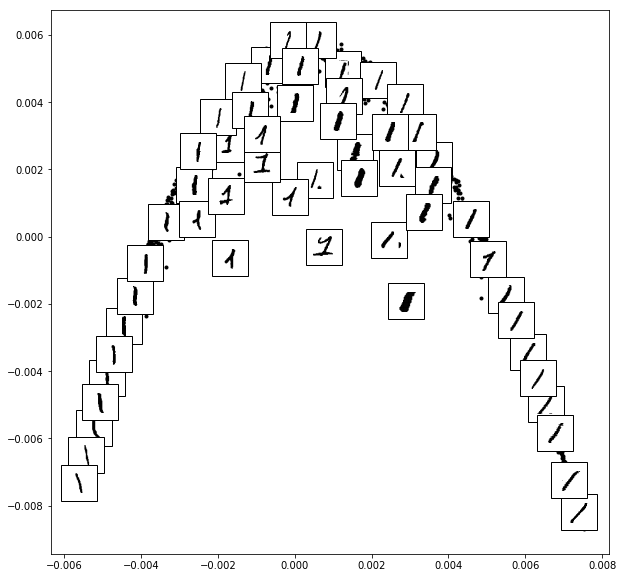

In [1475]:
# Choose 1/4 of the "1" digits to project
data = np.array(train[train.Y == 1][::4])
#L=LLE(k=30, p=2, verbose=True)
L = LEM(k=30, p=2, gamma=50)
train_new = L.fit_transform(data[:, :-1], data[:, -1], reg=1e-3)
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(data, np.array(train_new)[:, :-1], images=data[:, :-1].reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

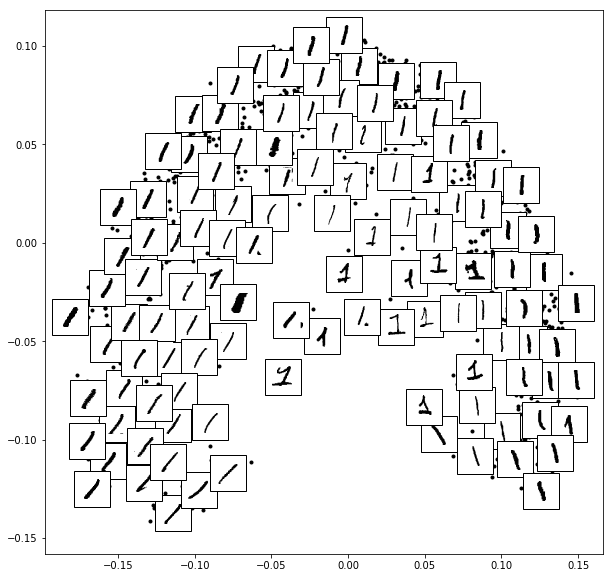

In [1474]:
# Choose 1/4 of the "1" digits to project
data = np.array(train[train.Y == 1][::4])
method = polynomial
d = 1
kpca = kernelPCA(method, {'d': d}, 2, verbose=False)
train_new = kpca.fit_transform(data)
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(data, np.array(train_new)[:, :-1], images=data[:, :-1].reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')